**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from several sources such as: [Gavin Simpson](https://gavinsimpson.github.io/physalia-gam-course/day-2/index.html#1) y [Noam Ross](https://noamross.github.io/gams-in-r-course/) and Generalized Additive Models by Simon Wood (2017). Every effort has been made to trace copyright holders of the materials used in this notebook. The author apologizes for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

In [ ]:
install.packages("here")

# Generalized Additive Model (GAMs)

Los GAMs son modelos GLM con un predictor lineal que lo conforma una suma de funciones suavizadoras de covariables. En otras palabras los GAMs incorporan funciones no-lineales como coeficientes de las covariables, y tienen la siguiente estructura:

$
g(E(Y))=f(x_1)++f(x_2)+...+f(x_p)
$

Donde $Y$, la respuesta variable, corresponde a una distribución de la familia exponencial. $E(Y)$ denota el valor medio, y $g(Y)$ la función *link* que relaciona el valor esperado de $Y$ con las variables predictoras, y $f_i$ son funciones no-paramétricas de las covariables ($x_p$) denominadas *smooths*. El término no-paramétrico hace referencia que la forma de la función predictora está completamente determinada por los datos.

Para explicar los GAMs utilizaremos los datos de mototes de carros y su capacidad cilíndrica.

In [ ]:
require(gamair)

In [4]:
data(engine)
attach(engine)

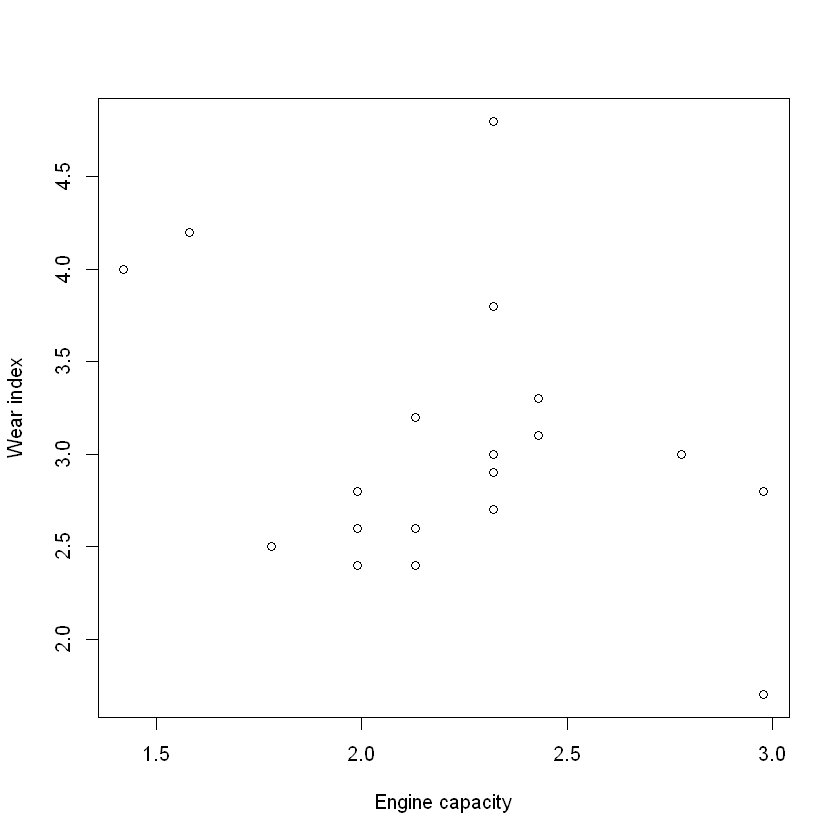

In [4]:
plot(size,wear,xlab="Engine capacity",ylab="Wear index")

In [5]:
tf=function(x,xj,j){
    dj=xj*0
    dj[j]=1
    approx(xj,dj,x)$y
}

In [6]:
tf.X=function(x,xj){
    nk=length(xj)
    n=length(x)
    X=matrix(NA,n,nk)
    for (j in 1:nk) X[,j]=tf(x,xj,j)
    X
}

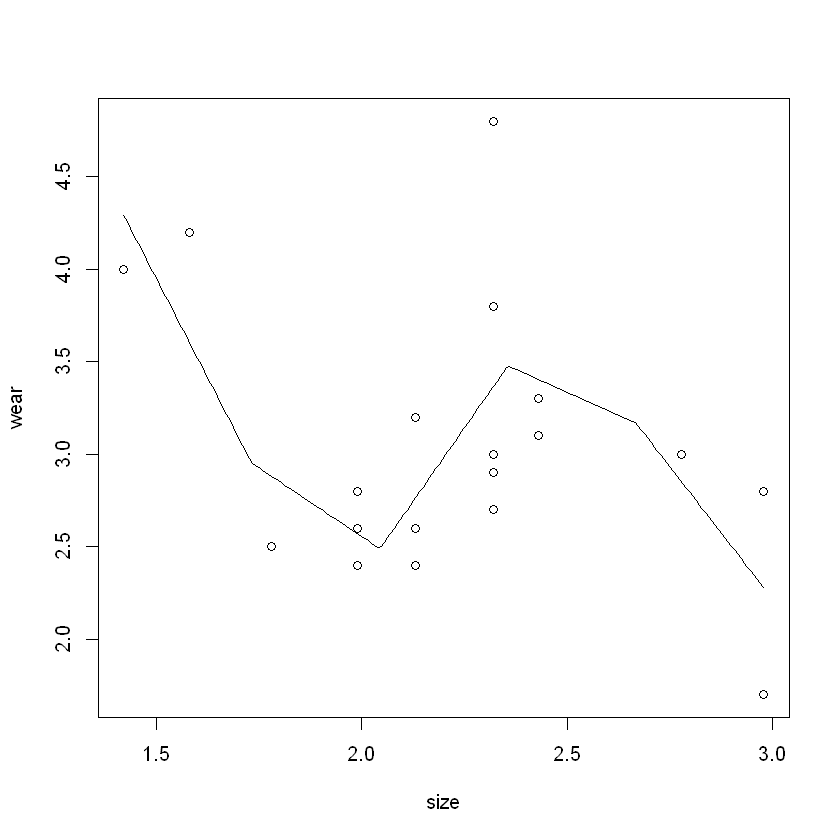

In [10]:
sj=seq(min(size),max(size),length=6) #genera los knots
X=tf.X(size,sj) # se creo el modelo de matrix
b=lm(wear~X-1) #ajustar modelo
s=seq(min(size),max(size),length=200) #datos de prediccion
Xp=tf.X(s,sj) #predecir los datos
plot(size,wear) #plotear los datos
lines(s,Xp %*% coef(b)) #estimado f

El anterior ajuste del modelo está determinado por la longitud de tramos, en este caso k=6. Una alternativa para establecer el ajuste adecuado es incluir una penalización que controle el ajuste del modelo. El parámetro de ajuste ($\lambda$) controla el *trade-off* entre el ajuste a los datos y la realidad de los datos. Cuando $\lambda -> \infty$ se obtiene una linea recta para el estimador $f$, cuando $\lambda -> 0$ se obtiene un modelo sin penalización.

A continuación se crea una función que permite establecer el número de tramos ($k$) y con una penalización ($\lambda$), lo cual determina el nivel de ajuste a los datos.

In [16]:
prs.fit=function(y,x,xj,sp){
    X=tf.X(x,xj) 
    D=diff(diag(length(xj)),differences=2) #sqrt penalty
    X=rbind(X,sqrt(sp)*D)
    y=c(y,rep(0,nrow(D)))
    lm(y~X-1) #ajuste minimo cuadrados penalizado
}

Con esta función, un $k=20$ y $\lambda=2$ se obtiene:

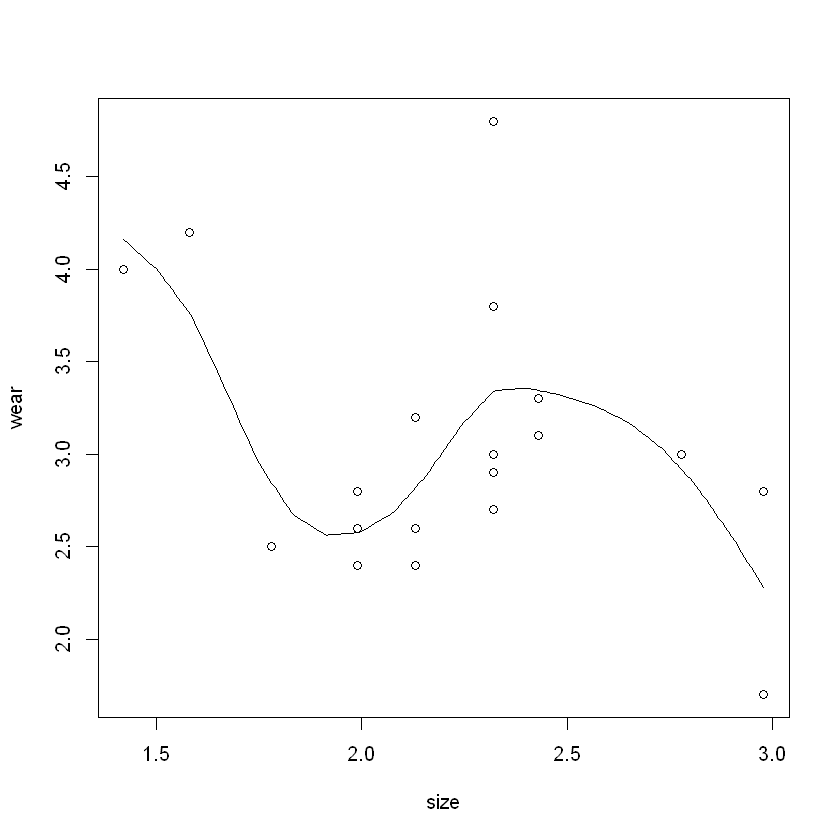

In [17]:
sj=seq(min(size),max(size),length=20) #k=20
b=prs.fit(wear,size,sj,2) #lambda=2
plot(size,wear)
Xp=tf.X(s,sj)
lines(s,Xp %*% coef(b))

Para un $k=100$ y $\lambda=0.01$

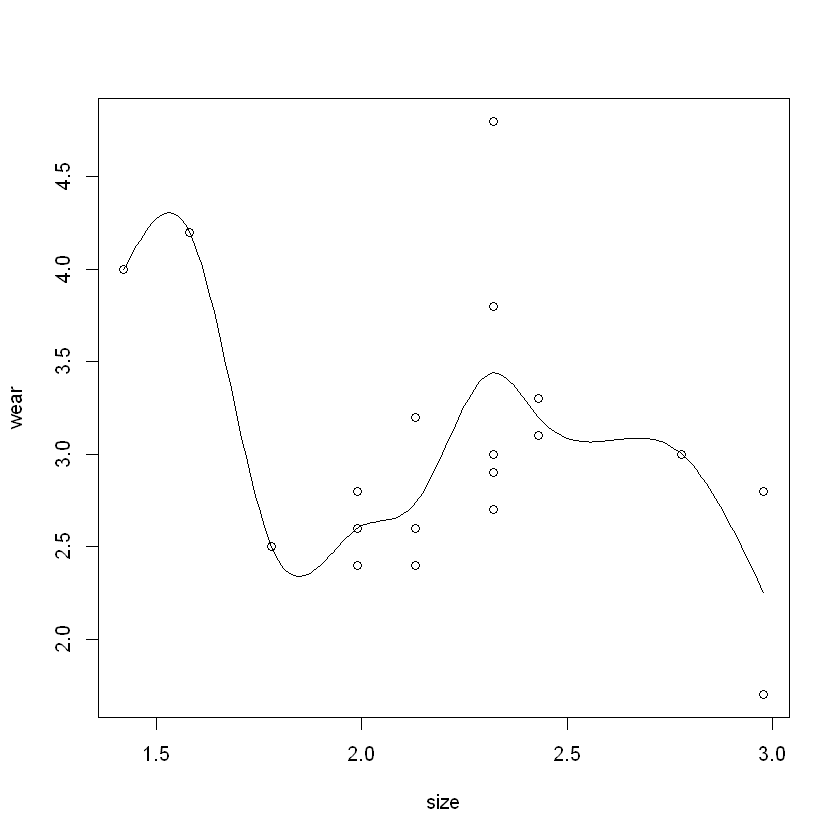

In [19]:
sj=seq(min(size),max(size),length=100)
b=prs.fit(wear,size,sj,0.01)
plot(size,wear)
Xp=tf.X(s,sj)
lines(s,Xp %*% coef(b))

## Librería *mgcv* para GAMs

Existen principalmente dos paquetes en R para modelos GAMs, *gam* y *mgcv*. El paquete *gam* está escrito por Trevor Hastie con un enfoque frecuentista, mientras que el paquete *mgcv* por Simon Wood con un enfoque Bayesiano. Este último es mas general ya que incorpora los GAMs como un caso de penalización de los GLMs.

Para explorar la librería *mgcv* utilizaremos los datos del *cherry tree data*

In [ ]:
library(mgcv)
data(trees)
trees

Vamos a crear el siguiente modelo:
$
log(E[Volume_i])=f_1(Height_i)+f_2(Girth_i) 
$
donde $Volume \sim gamma$

In [31]:
ct1=gam(Volume~s(Height)+s(Girth),family=Gamma(link=log),data=trees)
ct1


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth)

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008082356     

Estos resultados nos señalan la familia del modelo de distribución seleccionado (gamma), la función link, y la formula de la regresión. 

En cuanto a los grados de libertad del modelo, los resultados señalan que el efecto de la primera variable (Height) tiene un grado de libertad, por lo tanto es una linea recta, y el efecto de la segunda variable (Girth) tiene 2.4, por lo tanto corresponde a una curva. El número total de grados de libertad (total=4.42) corresponde a la suma de los grados de libertad de ambas variables mas un grado de libertad por el intercepto del modelo.

In [63]:
summary(ct1)


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.27570    0.01492   219.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df      F  p-value    
s(Height) 1.000  1.000  31.32 7.07e-06 ***
s(Girth)  2.422  3.044 219.28  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.973   Deviance explained = 97.8%
GCV = 0.0080824  Scale est. = 0.006899  n = 31

En este caso con la función *summary* se obtiene mas información del modelo, donde **Effective degrees of freedom (edf)** corresponde a los grados de libertad utilizados para función de suavización. En una regresion lineal tipica los grados de libertad del modelo es equivalente al número de covariables en el modelo. **Generalized cross validation (GCV)** corresponde al método para estimar los parámetros de suavizado y el valor puede ser entendido como el *mean square preddiction error* utilizando *leave-one-out*. Para esto también es utilizado el **Restricted Maximum Likelihood (REML)**, el cual converge más rápido que el *GCV*. El **Scale est.** es equivalente a la suma del cuadrado de los residuales, por lo tanto ambos son utilizados para evaluar el modelo. Finalmente tambien se encuentran el $R^2$ que señala el procentaje de la varianza en $y$ que pueden explicar las variables incorporadas en el modelo.

La función *gam.check()* arroja información sobre el modelo estadístico, donde es importante revisar que el modelo converga, asi como los *p-values* de cada covariable. Pequeños *p-values* indican que los residuos no están distribuidos aleatoriamente. Esto generalmente se presenta cuando no hay suficientes funciones bases. Como lo señala el resultado *k-index* > 1 y *p-value* >0.05. En este caso ambas covariables pasan el test. Finalmente, también se obtienen los gráficos de los residuos.


Method: GCV   Optimizer: outer newton
full convergence after 11 iterations.
Gradient range [-4.115787e-09,-2.484373e-09]
(score 0.008082356 & scale 0.006898968).
Hessian positive definite, eigenvalue range [4.115733e-09,0.0003338599].
Model rank =  19 / 19 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

            k'  edf k-index p-value
s(Height) 9.00 1.00    1.23    0.92
s(Girth)  9.00 2.42    1.06    0.54


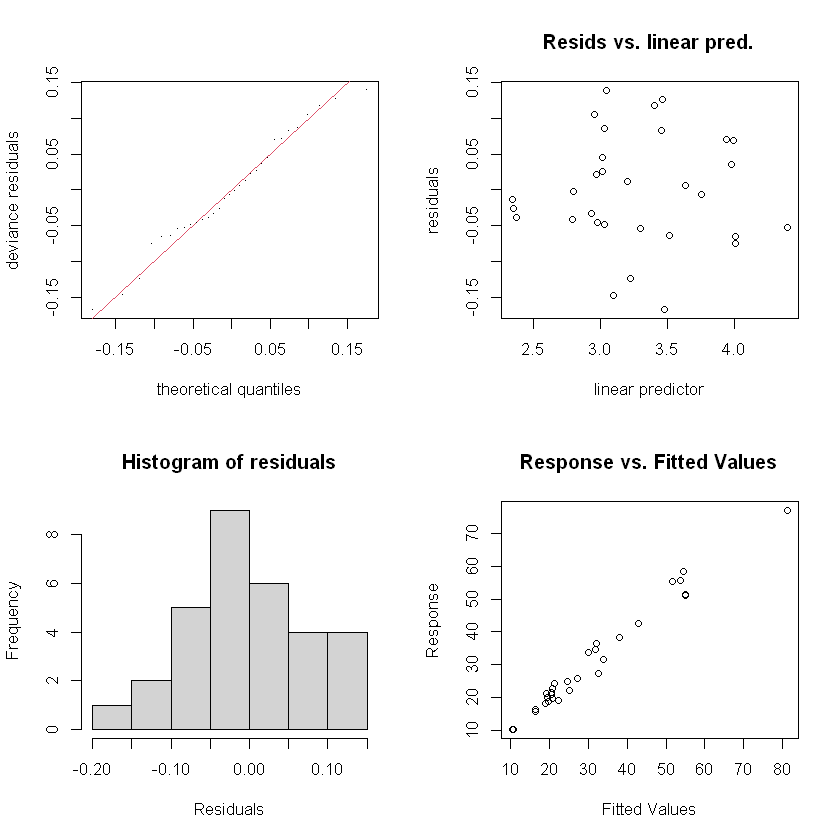

In [32]:
gam.check(ct1)

Otra característica importante de revisar en el modelo es la *concurvity*, la cual se refiere al grado de colinealidad que puede existir entre las variables, lo cual se manifiesta con valores muy altos de los intervalos de confianza.

In [33]:
concurvity(ct1,full=TRUE)

,para,s(Height),s(Girth)
worst,2.815665e-19,0.9021993,0.9021993
observed,2.815665e-19,0.4815222,0.4392988
estimate,2.815665e-19,0.4756779,0.4565423


La función presenta tres formas diferentes de evaluar, siempre será mas conservador orientarse por *worst*, si se obtienen valores altos por encima de 0.8 es mejor revisar nuevamente el modelo. Utilizar esta función con *FALSE* puede ayudar a identificar las variables que se correlacionan.

In [34]:
concurvity(ct1,full=FALSE)

,para,s(Height),s(Girth)
para,1.000000e+00,9.737099e-20,4.706169e-21
s(Height),9.737144e-20,1.000000e+00,9.021993e-01
s(Girth),4.705837e-21,9.021993e-01,1.000000e+00
,para,s(Height),s(Girth)
para,1.000000e+00,4.098252e-38,9.169135e-29
s(Height),9.737144e-20,1.000000e+00,4.392988e-01
s(Girth),4.705837e-21,4.815222e-01,1.000000e+00
,para,s(Height),s(Girth)
para,1.000000e+00,4.426339e-22,8.369718e-24
s(Height),9.737144e-20,1.000000e+00,4.565423e-01


A continuación se grafica los efectos estimados de cada variable con los límites de confidencia del 95%. Los puntos corresponden a residuales parciales, es decir la función evaluada para cada covariable.

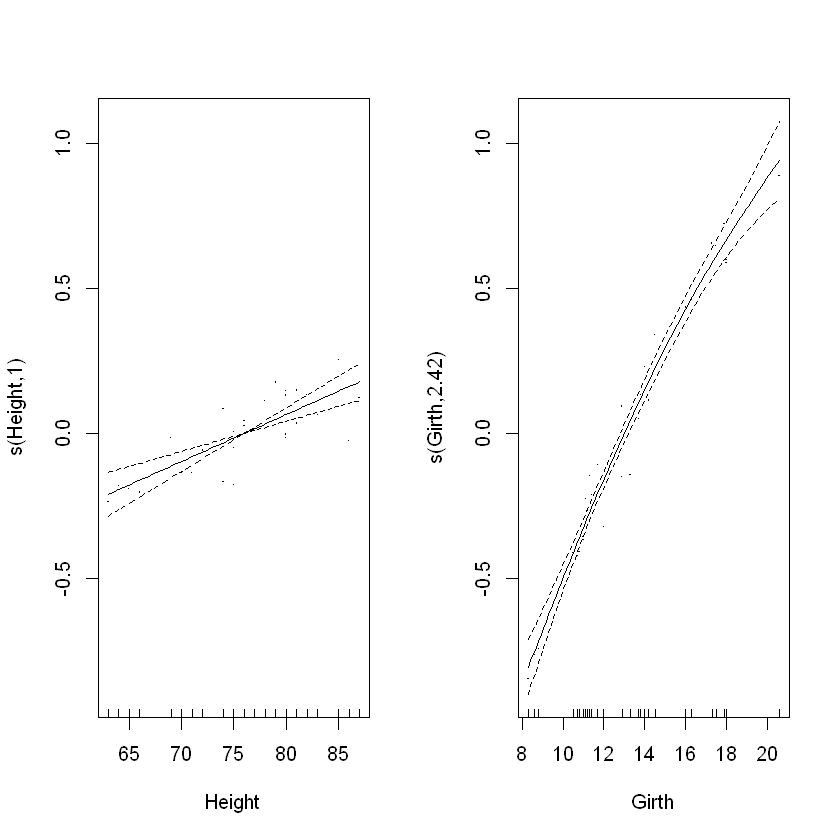

In [43]:
par(mfrow=c(1,2))
plot(ct1,residuals=TRUE)

Por defecto la librería utiliza como "smoother"el "plate regression splines", a continuación se utilizará con el argumento **bs** el "penalized cubric regression splines" (cr).

In [44]:
ct2=gam(Volume~s(Height,bs="cr")+s(Girth,bs="cr"),family=Gamma(link=log),data=trees)
ct2


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height, bs = "cr") + s(Girth, bs = "cr")

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008080514     

Los resultados no han cambiado mucho con el cambio del "smoother". Otro término para ajustar se refiere a la dimensión **k**, el cual se refiere al **máximo grado de libertad** o número de funciones bases para conformar los términos de las funciones suavizadoras. El número de funciones bases tiene un gran impacto en la forma que pueda tomar el modelo. El mejor valor a partir de dicho máximo es estimado a partir de los datos por GCV u otro criterio de seleccion de suavizado.

In [45]:
ct3=gam(Volume~s(Height)+s(Girth,bs="cr",k=20),family=Gamma(link=log),data=trees)
ct3


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth, bs = "cr", k = 20)

Estimated degrees of freedom:
1.00 2.42  total = 4.42 

GCV score: 0.008082974     

Tampoco se observan cambios en el modelo ya que el valor por defecto aplica para el valor efectivo utilizado para cada variable, 1 y 2,4. Otro parámetro corresponde al **gamma** el cual es usado para multiplicar los grados de libertad efectivos del modelo en el GCV o UBRE para aumentar el suavisado seleccionado. El valor por defecto de *gamma* es 1. GCV tiende a sobreajustar por lo que se sugiere utilizar $\gamma=1.5$.

In [46]:
ct4=gam(Volume~s(Height)+s(Girth),family=Gamma(link=log),data=trees,gamma=1.4)
ct4


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth)

Estimated degrees of freedom:
1.00 2.17  total = 4.17 

GCV score: 0.009228008     

El aumento de $\gamma$ ha reducido los grados de libertad efectivos utilizado. 

El suavizado tambien se ajusta por el denominado **parametro de suavizado ($\lambda$)**, el cual es estimado por el modelo a partir de los datos, sin embargo es posible parametrizarlo mediante el argumento *sp*, valores muy altos de penalización implica obtener funciones lineales. La librearía *mgcv* ofrece diferentes métodos para seleccionar los parámetros de suavizado, generalmente se recomienda utilizar "Restricted Maximum Likelihood (REML)"

In [7]:
ct_sp=gam(Volume~s(Height,sp=0.1)+s(Girth),family=Gamma(link=log),data=trees,method="REML")
ct_sp


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height, sp = 0.1) + s(Girth)

Estimated degrees of freedom:
3.53 2.47  total = 7 

REML score: 79.87269     

El suavizado puede aplicarse a cualquier número de covariables utilizando dos tipos de suavizado: **s()** que genera suavizados isotrópicos utilizando las bases *tp, ds, gp*, o **te()** que produce suavizados de cualquier base penalizada, incluyendo la mezcla de bases. Las interacciones co tensores (*te()*) son mas apropiados para variables con diferentes escalas o unidades, ya que tiene parámetro de suavizado para cada variable.

En el siguiente ejemplo se modela la interacción de las dos variables (*Height* y *Girth*):

In [47]:
ct5=gam(Volume~s(Height,Girth,k=25),family=Gamma(link=log),data=trees)
ct5


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height, Girth, k = 25)

Estimated degrees of freedom:
4.79  total = 5.79 

GCV score: 0.009357594     

Como resultado se obtiene el intercepto y un solo coeficiente para dicha interacción, el cual combina el efecto de *Height*, el de *Girth* y el de *HeightxGirth*, y generalmente requiere mas grados de libertad o funciones bases para poder construir una superficie en lugar de una linea.

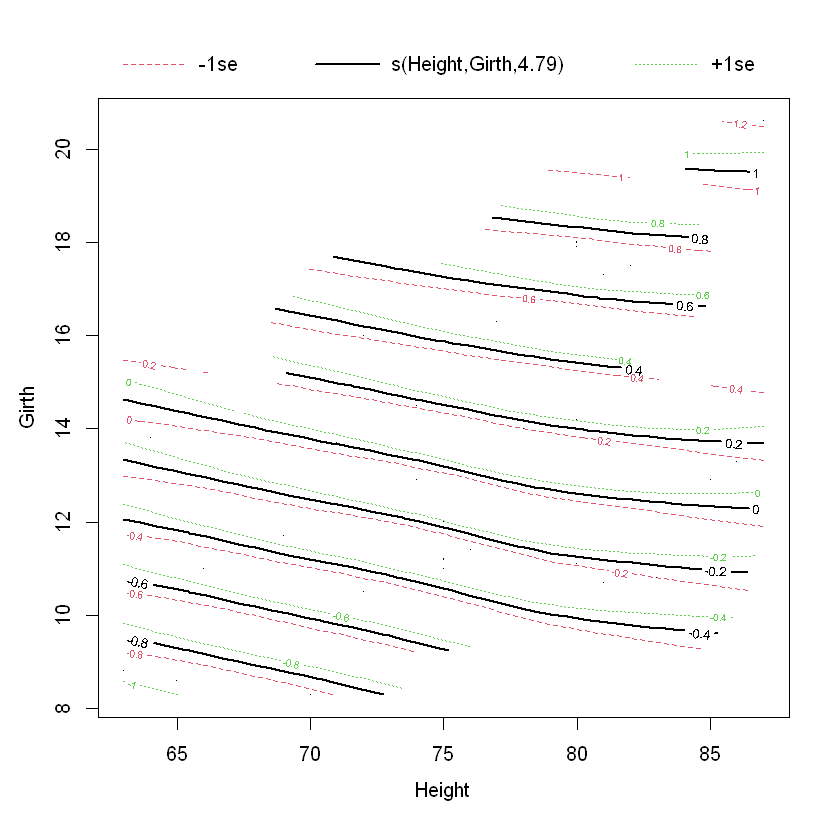

In [49]:
plot(ct5,too.far=0.15)

Los resultados de graficar la interacción de ambas variables muestra un mapa topográfico con los valores predichos. Este tambien puede verse como una superficie 3D definiendo *scheme=1*.

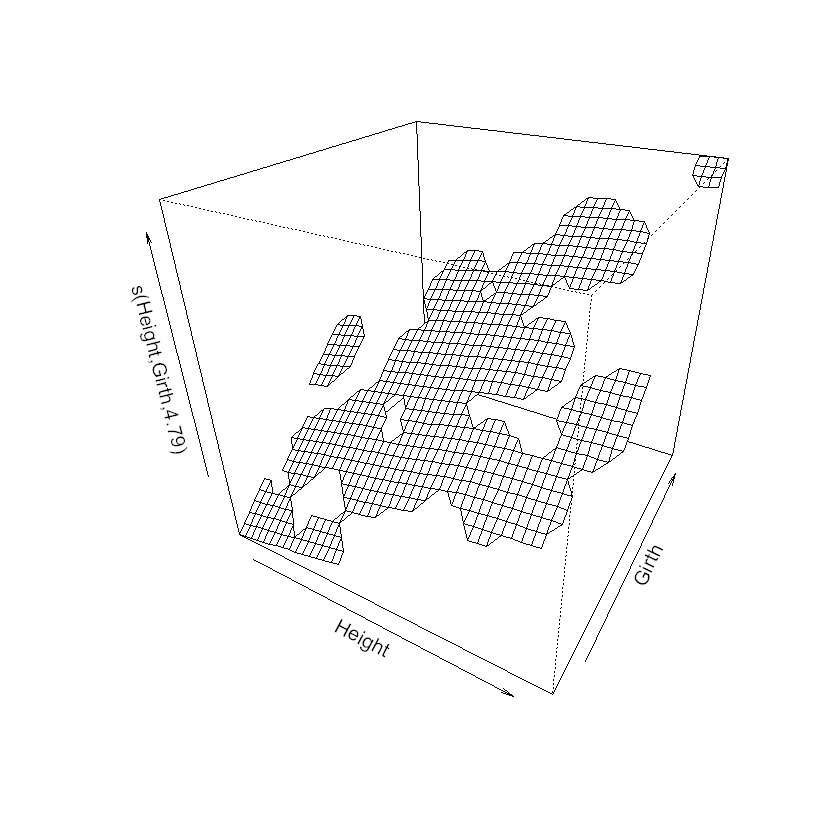

In [92]:
plot(ct5,scheme=1)

con *scheme=2* nos presenta un mapa de calor:

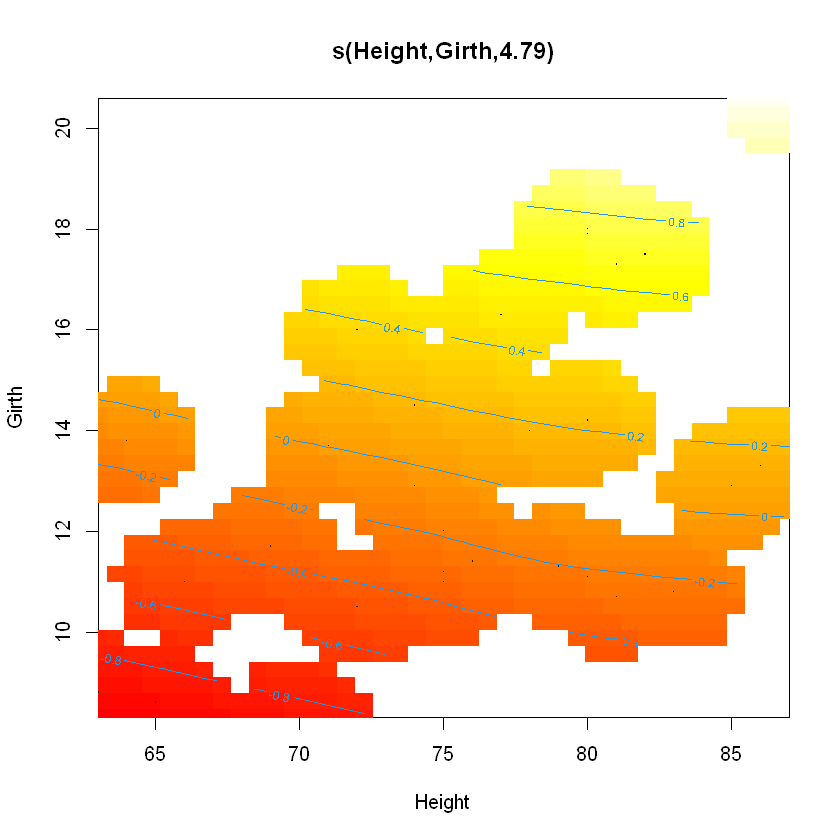

In [93]:
plot(ct5,scheme=2)

In [41]:
ct6=gam(Volume~te(Height,Girth,k=c(5,10)),family=Gamma(link=log),data=trees)
ct6


Family: Gamma 
Link function: log 

Formula:
Volume ~ te(Height, Girth, k = c(5, 10))

Estimated degrees of freedom:
21.8  total = 22.8 

GCV score: 0.006172976     

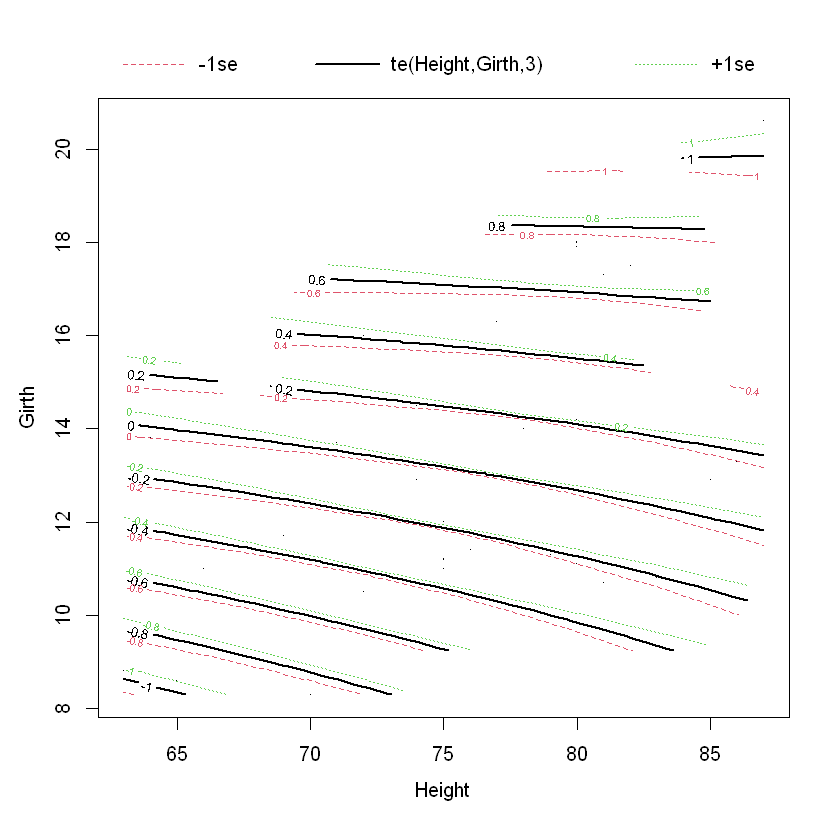

In [51]:
plot(ct6,too.far=0.15)

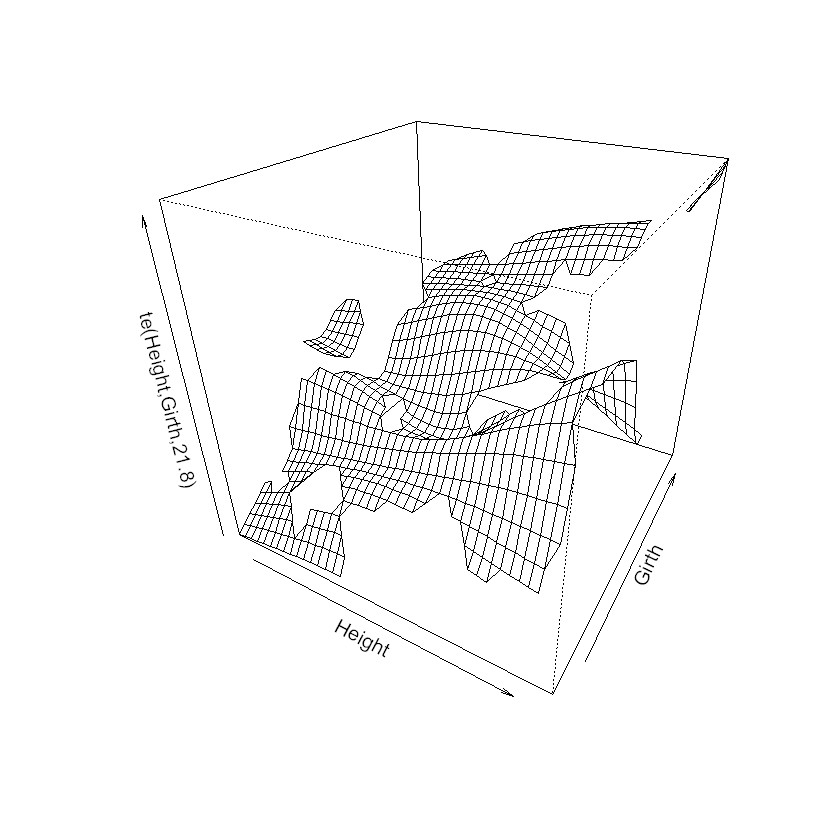

In [42]:
plot(ct6,scheme=1)

El modelo tipo tensor *(te())* tiene menos grados de libertad y menor GCV que el suavizado *se()*. En realidad, con sólo 3 grados de libertad, el producto tensor suaviza el modelo.

$
log(E[Volume_i])=\beta_0+\beta_1Height_i+\beta_2Girth_i+\beta_3Height_iGirth_i
$

Las interacciones con tensores *te()* permite separar las interacciones de forma individual, es decir la interacción entre dos variables, pero no sus efectos independientes.

In [46]:
ct_ti=gam(Volume~s(Height) + s(Girth) + ti(Height,Girth),family=Gamma(link=log), data=trees)
summary(ct_ti)


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Height) + s(Girth) + ti(Height, Girth)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.30014    0.01704   193.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(Height)          1      1  22.27 6.57e-05 ***
s(Girth)           1      1 619.62  < 2e-16 ***
ti(Height,Girth)   1      1  10.05  0.00377 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.973   Deviance explained = 97.7%
GCV = 0.0081971  Scale est. = 0.0071821  n = 31

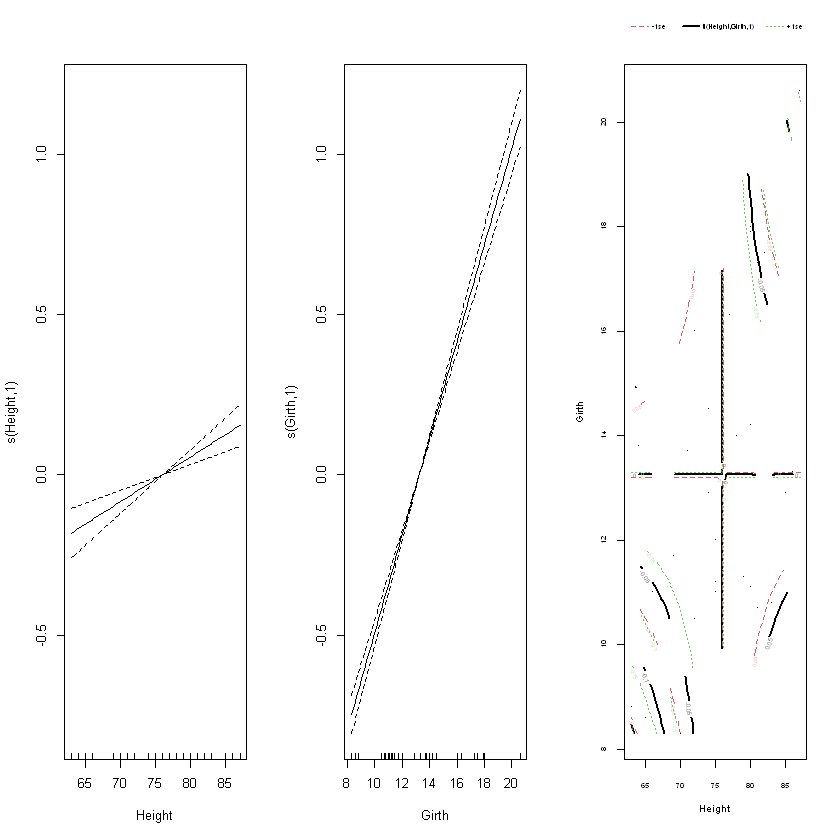

In [47]:
par(mfrow=c(1,3))
plot(ct_ti,all.terms=TRUE)

La interacción de variables nos permite modelar de forma mas acertada datos espaciales. Para esto se puede utilizar un término de interacción con las coordenadas *x* y *y* a lo largo de términos individuales para otros predictores. El término de interacción incorpora la estructura espacial de los datos.

Es posible mezclar covariables con coeficientes paramétricos, por ejemplo:

In [53]:
ct7=gam(Volume~Height+s(Girth),family=Gamma(link=log),data=trees)
ct7


Family: Gamma 
Link function: log 

Formula:
Volume ~ Height + s(Girth)

Estimated degrees of freedom:
2.42  total = 4.42 

GCV score: 0.008082352     

Otro ejemplo es incorporar variables categóricas. En el siguiente ejemplo se transforma la primera covariable:

In [36]:
trees$Hclass=factor(floor(trees$Height/10)-5,labels=c("small","medium","large"))

In [37]:
ct8=gam(Volume~Hclass+s(Girth),family=Gamma(link=log),data=trees,gamma=1.4)
ct8


Family: Gamma 
Link function: log 

Formula:
Volume ~ Hclass + s(Girth)

Estimated degrees of freedom:
2.14  total = 5.14 

GCV score: 0.0143318     

In [59]:
summary(ct8)


Family: Gamma 
Link function: log 

Formula:
Volume ~ Hclass + s(Girth)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.12417    0.04936  63.287  < 2e-16 ***
Hclassmedium  0.13907    0.05570   2.497  0.01925 *  
Hclasslarge   0.23247    0.06299   3.691  0.00105 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(Girth) 2.141  2.713 168.6  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.967   Deviance explained = 96.9%
GCV = 0.014332  Scale est. = 0.010409  n = 31

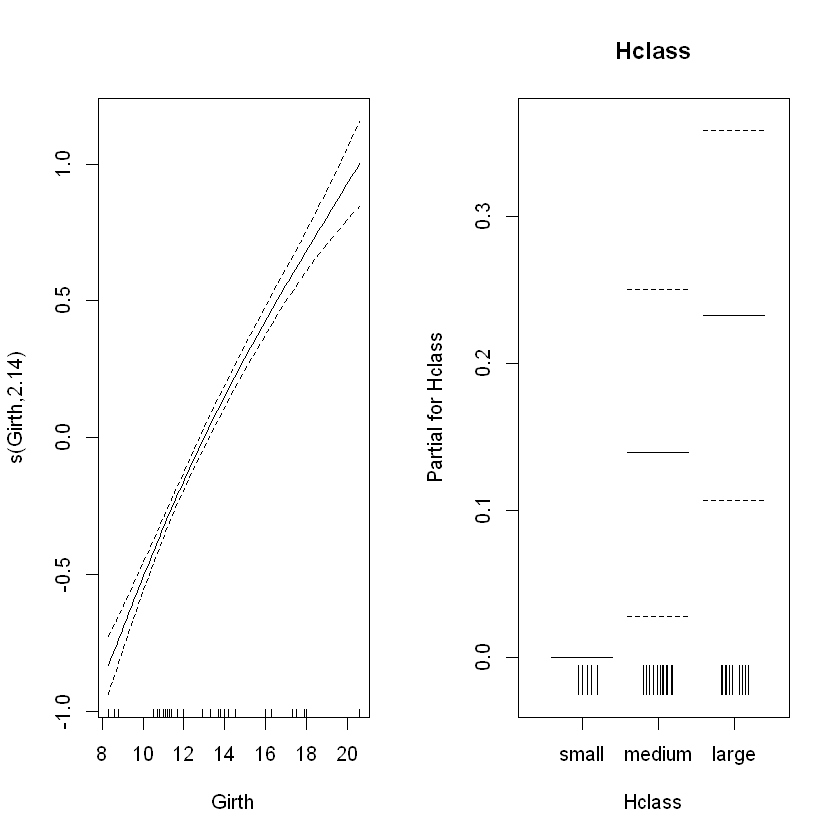

In [58]:
par(mfrow=c(1,2))
plot(ct8,all.terms=TRUE)

Es posible para este caso de variables categóricas ajustar diferentes funciones de suavizado para cada clase de la variable categórica de la siguiente forma: 

In [11]:
ct9=gam(Volume~s(Girth,by=Hclass),family=Gamma(link=log),data=trees)
ct9


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Girth, by = Hclass)

Estimated degrees of freedom:
3.52 5.89 1.00  total = 11.4 

GCV score: 0.01300756     

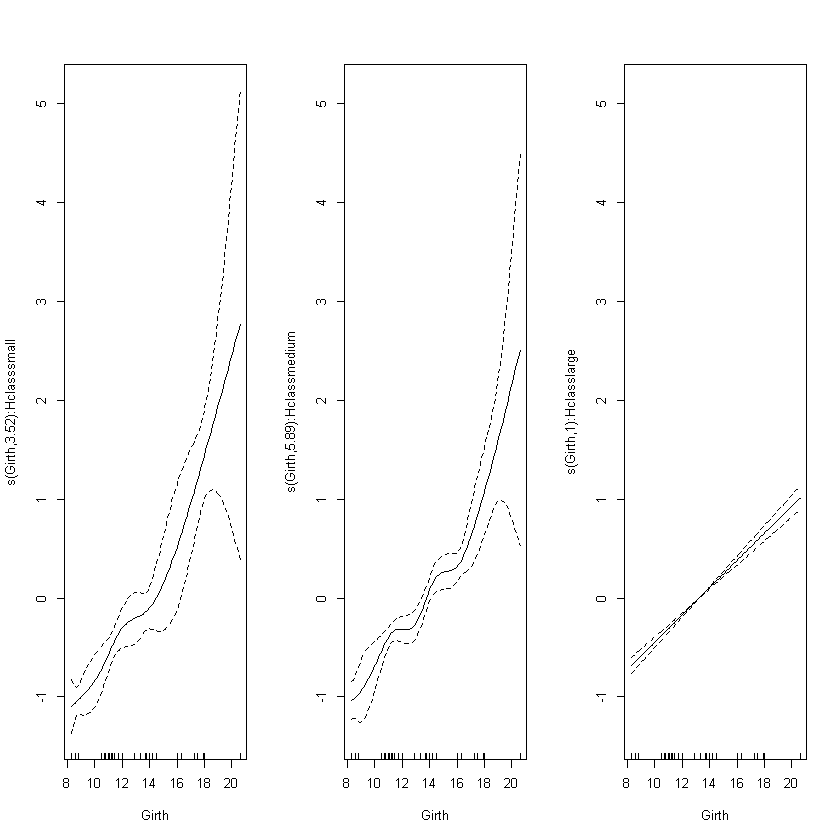

In [13]:
par(mfrow=c(1,3))
plot(ct9,all.terms=TRUE)

Otra forma de incorporar la interacción entre variables continuas y categóricas, denominada **factor-smooth** de la siguiente forma:

In [38]:
ct10=gam(Volume~s(Girth,Hclass,bs="fs"),family=Gamma(link=log),data=trees)
ct10


Family: Gamma 
Link function: log 

Formula:
Volume ~ s(Girth, Hclass, bs = "fs")

Estimated degrees of freedom:
14.3  total = 15.33 

GCV score: 0.0132143     

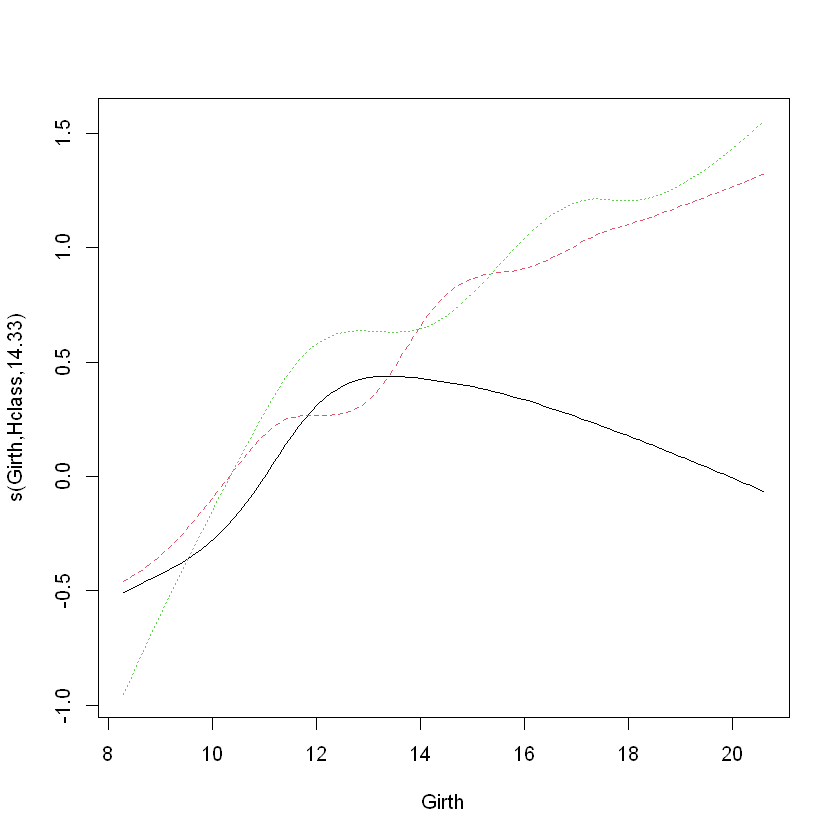

In [39]:
plot(ct10,all.terms=TRUE)

Como se observa, en este caso solo se obtiene un valor de la interaccióm, no discrimina, sin embargo se obtiene una gráfica para cada clase.

## Ejemplo

In [ ]:
library(readr)
library(ggeffects)
library(ggplot2)
library(magrittr)
library(tidyverse)

In [ ]:
pisa=read_csv('https://raw.githubusercontent.com/m-clark/generalized-additive-models/master/data/pisasci2006.csv')
pisa

Para implementar un modelo linear estandar utilizamos:

In [61]:
mod_lm=gam(Overall~Income,data=pisa)
summary(mod_lm)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ Income

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   204.32      35.37   5.777 4.32e-07 ***
Income        355.85      46.79   7.606 5.36e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


R-sq.(adj) =  0.518   Deviance explained = 52.7%
GCV = 1504.5  Scale est. = 1448.8    n = 54

Para implementar un modelo GAMs con un suavizado cúbico con una distribución gaussiana utilizamos:

In [18]:
mod_gam1=gam(Overall~s(Income,bs="cr"),data=pisa)
summary(mod_gam1)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income, bs = "cr")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  470.444      4.082   115.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(Income) 6.895  7.741 16.67  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =    0.7   Deviance explained = 73.9%
GCV = 1053.7  Scale est. = 899.67    n = 54

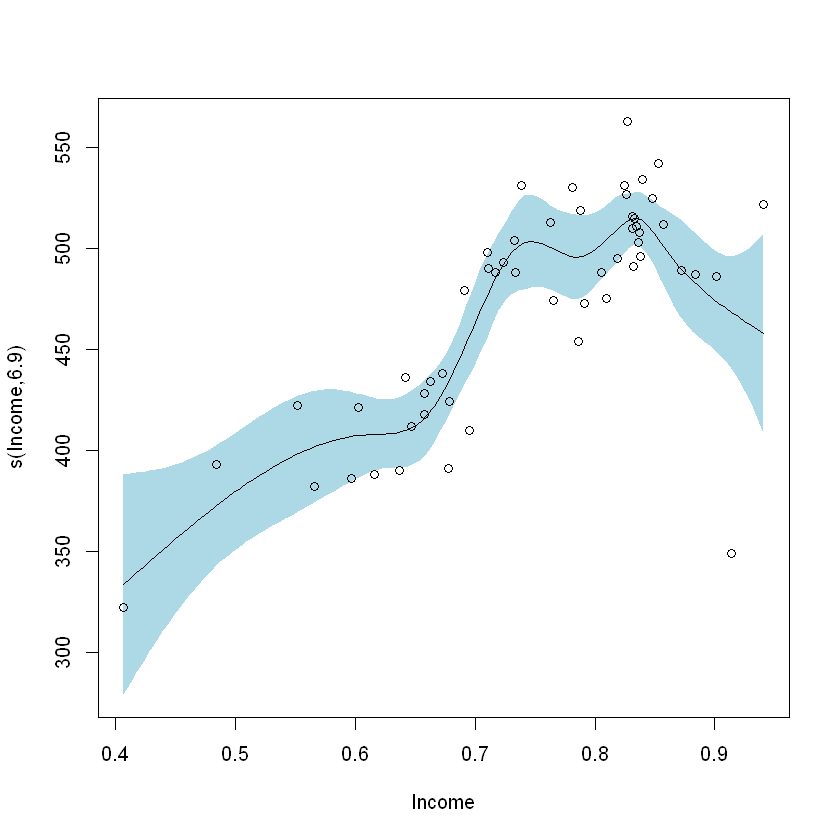

In [27]:
plot(mod_gam1, residuals=TRUE,pch=1,cex=1,rug=FALSE,se=TRUE, shade=TRUE,shade.col="lightblue",shift=coef(mod_gam1)[1])

El argumento *residuals* adiciona residuales parciales en la figura, los cuales corresponden a la diferencia entre los efectos parciales y los datos. El argumento *rug*, que por defecto se encuentra en *TRUE*, incluye o elimina la ubicación de los datos sobre el borde de la figura. Mientras que los argumentos *pch* y *cex* ajustan la forma y el tamaño de los puntos, respectivamente. El argumento *se* por defecto en TRUE permite graficar el intervalo de confianza del 95%. *shade* permite obtener dicho intervalo sombreado o con color con *shade.col*. El argumento *shift* ayuda para una mejor interpretación, ya que ajusta la escala de los ejes de acuerdo con el intercepto en este caso.

In [25]:
summary(mod_lm)$sp.criterion

GCV.Cp 
1504.496

In [26]:
summary(mod_gam1)$sp.criterion

GCV.Cp 
1053.727

In [27]:
summary(mod_lm)$r.sq

[1] 0.5175346

In [28]:
summary(mod_gam1)$r.sq

[1] 0.7003963

In [29]:
anova(mod_lm,mod_gam1,test="Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,52.0000,75336.24,NA,NA,NA
2,45.2589,41479.07,6.741103,33857.17,2.778437e-06


Para un modelo multivariado de regresión lineal estandar podemos utlizar:

In [30]:
mod_lm2 = gam(Overall ~ Income + Edu + Health, data = pisa)
summary(mod_lm2)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ Income + Edu + Health

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   121.18      78.97   1.535   0.1314    
Income        182.32      85.27   2.138   0.0376 *  
Edu           234.11      54.78   4.274 9.06e-05 ***
Health         27.01     134.90   0.200   0.8421    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


R-sq.(adj) =  0.616   Deviance explained = 63.9%
GCV = 1212.3  Scale est. = 1119      n = 52

La versión GAMs se puede estructurar de la siguiente forma:

In [31]:
mod_gam2 = gam(Overall ~ s(Income) + s(Edu) + s(Health), data = pisa)
summary(mod_gam2)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income) + s(Edu) + s(Health)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  471.154      2.772     170   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df     F  p-value    
s(Income) 7.593  8.415 8.826 1.29e-06 ***
s(Edu)    6.204  7.178 3.308  0.00771 ** 
s(Health) 1.000  1.000 2.736  0.10679    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.863   Deviance explained = 90.3%
GCV = 573.83  Scale est. = 399.5     n = 52

El caso de *Health* con 1 grado de libertad senala que el modelo ha reducido su efecto a lineal, por lo cual un modelo GAMs doden *Health* se defina como lineal, arroja el mismo resultado.


In [64]:
mod_gam2B = update(mod_gam2, . ~ . - s(Health) + Health)
summary(mod_gam2B)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ s(Income) + s(Edu) + Health

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    640.3      102.3   6.260 3.06e-07 ***
Health        -189.5      114.6  -1.654    0.107    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df     F  p-value    
s(Income) 7.593  8.415 8.826 1.29e-06 ***
s(Edu)    6.204  7.178 3.308  0.00771 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.863   Deviance explained = 90.3%
GCV = 573.83  Scale est. = 399.5     n = 52

In [67]:
# Note that mod_gam2$model is the data that was used in the modeling process, 
# so it will have NAs removed.
testdata = data.frame(
  Income = seq(.4, 1, length = 100),
  Edu    = mean(mod_gam2$model$Edu),
  Health = mean(mod_gam2$model$Health)
)

In [68]:
predictions = predict(mod_gam2,newdata = testdata,type = 'response',se = TRUE)

In [81]:
df_preds = data.frame(testdata, predictions) %>% mutate(lower = fit - 1.96 * se.fit, upper = fit + 1.96 * se.fit)

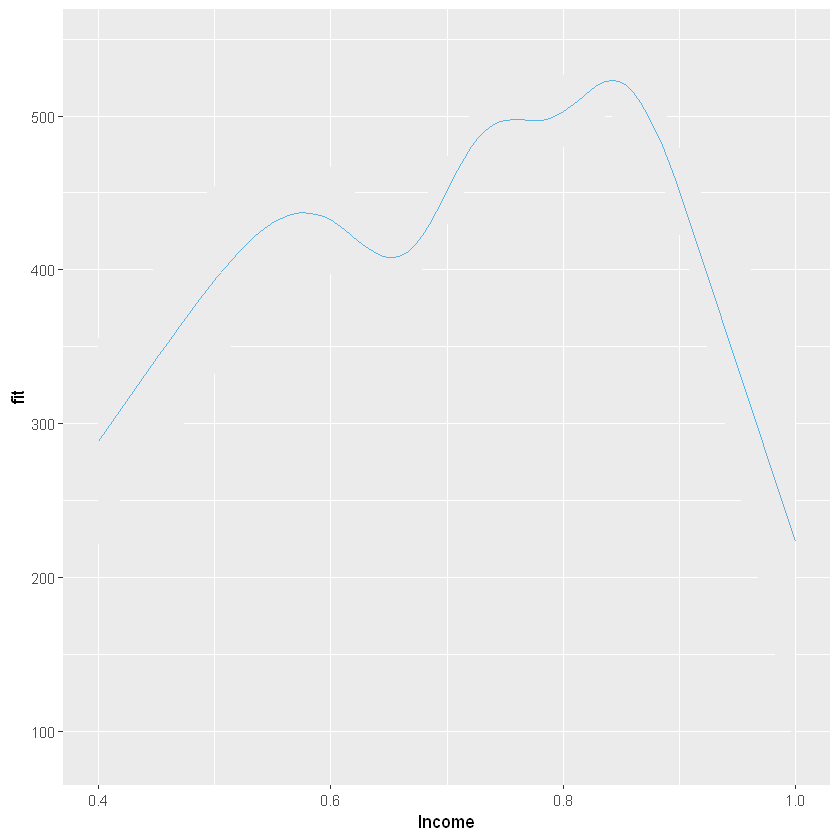

In [82]:
ggplot(aes(x = Income, y = fit), data = df_preds) +
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = 'gray92') +
  geom_line(color = '#56B4E9')

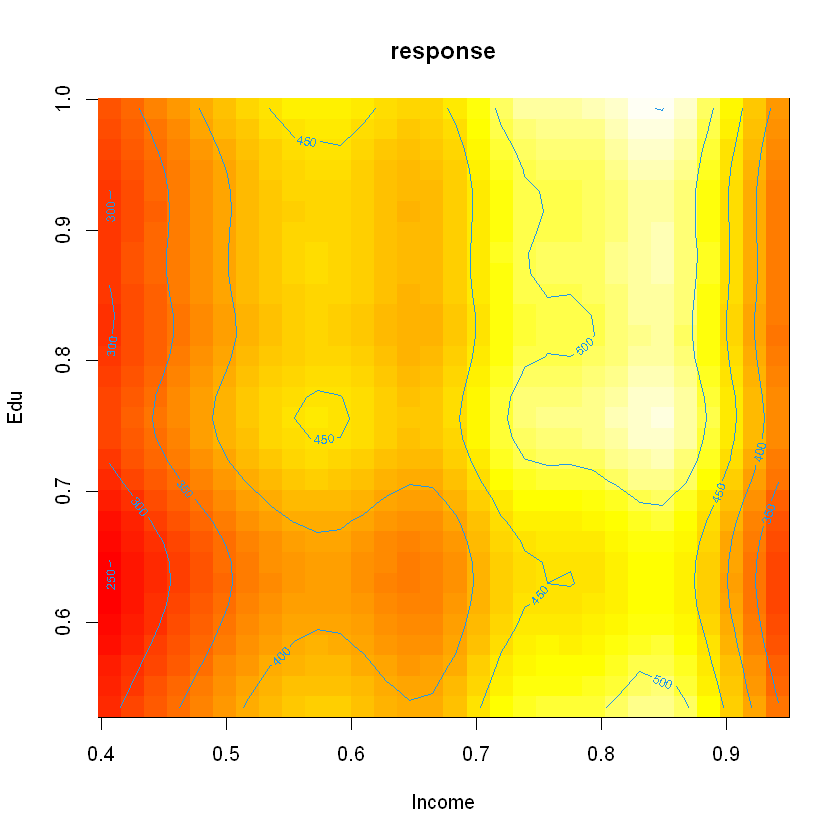

In [83]:
vis.gam(mod_gam2, type = 'response', plot.type = 'contour')

In [84]:
mod_gam3 = gam(Overall ~ te(Income, Edu), data = pisa)
summary(mod_gam3)


Family: gaussian 
Link function: identity 

Formula:
Overall ~ te(Income, Edu)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  471.154      3.349   140.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df     F p-value    
te(Income,Edu) 10.1  12.19 16.93  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =    0.8   Deviance explained =   84%
GCV = 741.42  Scale est. = 583.17    n = 52

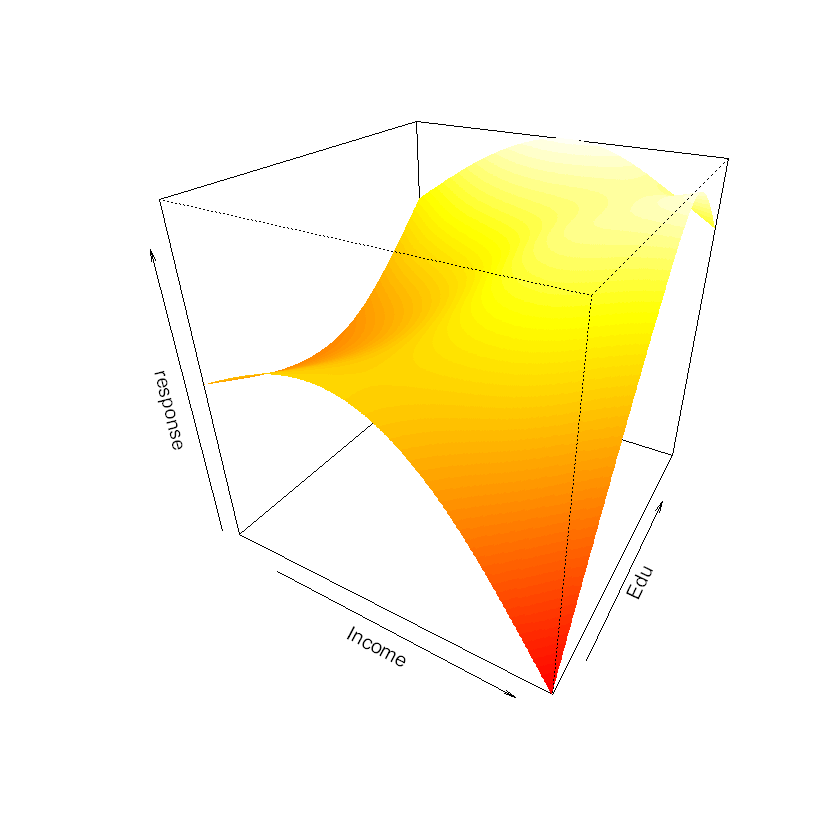

In [85]:
 vis.gam(
   mod_gam3,
   type      = 'response',
   plot.type = 'persp',
   phi       = 30,
   theta     = 30,
   n.grid    = 500,
   border    = NA
 )

In [86]:
anova(mod_lm2, mod_gam2, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,48.00000,53712.69,NA,NA,NA
2,34.40762,14463.18,13.59238,39249.51,6.753858e-15


## Ejemplo

In [ ]:
library('readr')
library('dplyr')
library('curl')
library('mgcv')
library("here")


In [6]:
larks <-  read_csv(here("data","larks.csv"),col_types = "ccdddd")
larks <- larks %>% mutate(crestlark = factor(crestlark),linnet = factor(linnet),e = x / 1000,n = y / 1000)
head(larks)

QUADRICULA,TET,crestlark,linnet,x,y,e,n
<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
NG56,E,NA,NA,551000,4669000,551,4669
NG56,J,NA,NA,553000,4669000,553,4669
NG56,P,NA,NA,555000,4669000,555,4669
NG56,U,NA,NA,557000,4669000,557,4669
NG56,Z,NA,NA,559000,4669000,559,4669
NG66,E,NA,NA,561000,4669000,561,4669


Para implementar un modelo de regresión logística tipo GAM se utiliza la familia binomial de la siguiente manera:

In [13]:
crest <- gam(crestlark ~ s(e)+s(n),data = larks,family = binomial,method = 'REML')

In [14]:
summary(crest)


Family: binomial 
Link function: logit 

Formula:
crestlark ~ s(e) + s(n)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.83479    0.04718  -38.89   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
       edf Ref.df Chi.sq p-value    
s(e) 6.674  7.754  191.7  <2e-16 ***
s(n) 8.348  8.854  627.9  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.141   Deviance explained = 15.6%
-REML = 2714.6  Scale est. = 1         n = 6457

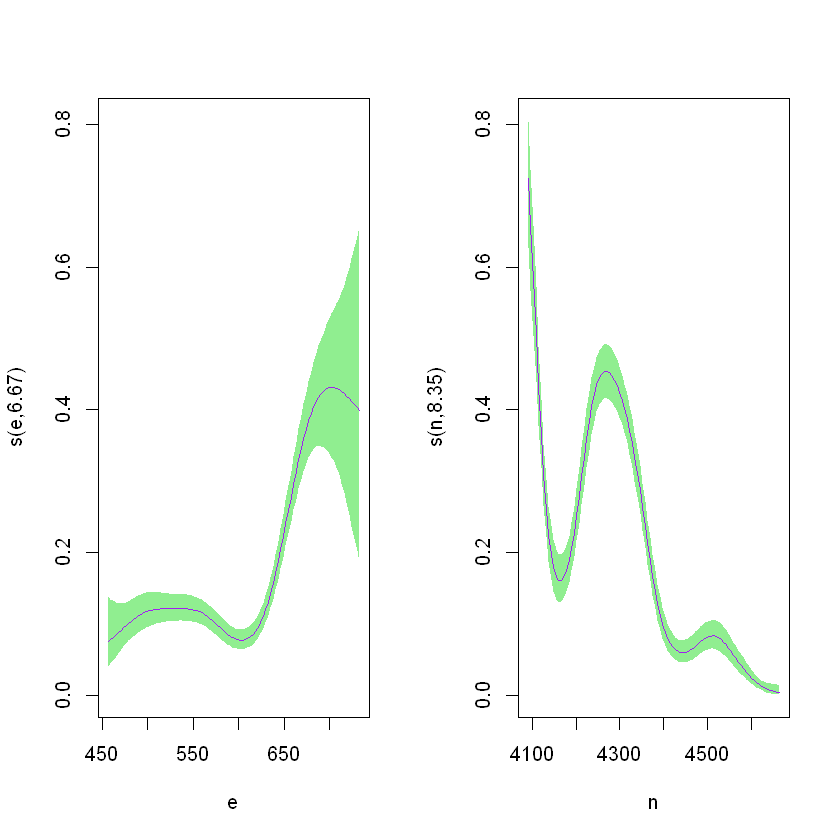

In [20]:
plot(crest,pages=1,trans=plogis,shift=coef(crest)[1],seWithMean = TRUE, rug = FALSE, shade = TRUE, shade.col = "lightgreen",col = "purple")

El efecto de cada covariable se presenta en la anterior figura, dodne el argumetno de la función **trans=plogis** transforma la salida de $Y$ en probabilidades, y el argumento **shift** incorpora el intercepto, permitiendo leer directamente el efecto de cada covariable en $Y$, y la función **seWithMean** que incorpora la incertidumbre del intercepto a la incertidumbre del suavizado.|

Para predecir se utiliza la función **predict()**, sin embargo la escala de los datso obtenidos puede ser tipo *link* que corresponde a la escalalos *log-odds* en el caso de un regresión losgística, y de tipo *response* transformada a la escala de $Y$, en este caso a probabilidades entre 1 y 1.

In [ ]:
predict(crest, type = "link")

In [ ]:
predict(crest, type = "response")

Incorporando el argumento *se.fit* se obtienen el error estandar de las predicciones.

In [ ]:
predict(crest, type = "response",se.fit=TRUE)